In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple

In [2]:
# from: https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

def intersectarea(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

def unionarea(a, b):
    aarea = (a.xmax-a.xmin) * (a.ymax-a.ymin)
    barea = (b.xmax-b.xmin) * (b.ymax-b.ymin)
    intersect = intersectarea(a, b)
    union = aarea + barea - intersect
    return aarea, barea, union

In [19]:
def measureboxperformance(result, accthres=0):
    overlapping = 0
    IoU = 0
    DistBoxCenter = 0
    count = 0
    
    for k in range(len(result)):
        image = plt.imread(result.iloc[k]['filepath'])
        # Calculate edges of bounding boxed detected (d) and ground truth (g)
        s = result.iloc[k]
        d1,d2 = s['p_bb0']*image.shape[0], s['p_bb2']*image.shape[0]
        d3,d4 = s['p_bb1']*image.shape[1], s['p_bb3']*image.shape[1]

        g1,g2 = s['g_bb_y1'], s['g_bb_y2']
        g3,g4 = s['g_bb_x1'], s['g_bb_x2']

        rd = Rectangle(d3,d1,d4,d2)
        rg = Rectangle(g3,g1,g4,g2)

        intersect = intersectarea(rd, rg)
        darea, garea, union = unionarea(rd,rg)

        dm = np.array([(rd.xmax+rd.xmin) / 2, (rd.ymax+rd.ymin) / 2])
        gm = np.array([(rg.xmax+rg.xmin) / 2, (rg.ymax+rg.ymin) / 2])
        
        if float(s['accuracy']) >= accthres:
            count += 1
            IoU += intersect / union
            DistBoxCenter += np.linalg.norm(dm-gm)

            if intersect > 0:
                overlapping += 1
    if count > 0:  
        return [IoU/count, DistBoxCenter/count, overlapping]
    else:
        return [0,0,0]

In [4]:
# Read predicted values
predictions = pd.read_csv('results/TestsetPositionsBall.csv', 
                          names=['filepath', 'boundingbox', 
                                 'accuracy', 'labelnum', 'num'])

In [5]:
# Split filename for join
predictions['filename'] = pd.Series([x.split('/')[-1] 
                                     for x in predictions['filepath']])

In [6]:
# Split boundingbox array into single x and y-values
for i in range(4):
    ser = pd.Series([float(x.strip('][').replace('    ', ' ')
                           .replace('  ', ' ').replace('  ', ' ')
                           .split(' ')[i]) 
                     for x in predictions['boundingbox']])
    predictions['p_bb' + str(i)] = ser

In [7]:
predictions = predictions.set_index('filename')
predictions.head()

,filepath,boundingbox,accuracy,labelnum,num,p_bb0,p_bb1,p_bb2,p_bb3
filename,,,,,,,,,
image_GP_00181.png,/home/mueller/code/python/Anwendungspraktikum/...,[0.21541114 0.5281907 0.22838908 0.5354454 ],0.286413,1.0,[100.],0.215411,0.528191,0.228389,0.535445
image_GP_00200.png,/home/mueller/code/python/Anwendungspraktikum/...,[0.18062638 0.53227025 0.19188395 0.5386476 ],0.474113,1.0,[100.],0.180626,0.532270,0.191884,0.538648
image_GP_00224.png,/home/mueller/code/python/Anwendungspraktikum/...,[0.17096928 0.5681412 0.1866014 0.57582176],0.422370,1.0,[100.],0.170969,0.568141,0.186601,0.575822
image_GP_00324.png,/home/mueller/code/python/Anwendungspraktikum/...,[0.750624 0.12874901 0.77998716 0.13985926],0.247143,1.0,[100.],0.750624,0.128749,0.779987,0.139859
image_GP_00368.png,/home/mueller/code/python/Anwendungspraktikum/...,[0.02385472 0.44712606 0.03271474 0.4557061 ],0.100450,1.0,[100.],0.023855,0.447126,0.032715,0.455706


In [8]:
# Read ground truth data
testfile = pd.read_csv('../annotations/GoProBall_test.txt', sep=' ', 
                       names=['filename', 'label', 'g_bb_x1', 
                              'g_bb_y1', 'g_bb_x2', 'g_bb_y2'])
testfile = testfile.set_index('filename')
testfile.head()

,label,g_bb_x1,g_bb_y1,g_bb_x2,g_bb_y2
filename,,,,,
image_GP_00181.png,Ball,1010,235,1021,248
image_GP_00200.png,Ball,1018,197,1029,210
image_GP_00224.png,Ball,1018,138,1030,153
image_GP_00324.png,Ball,247,809,277,843
image_GP_00368.png,Ball,872,17,884,33


In [9]:
# Join ground truth and predictions
result = testfile.join(predictions, how='inner')

In [10]:
print('Number of Testimages: ', len(result))

Number of Testimages:  78


In [21]:
x = np.linspace(0,np.max(result['accuracy']),15)
y = [measureboxperformance(result=result, accthres=t)[0] for t in x]

In [18]:
x

array([0.        , 0.06277943, 0.12555886, 0.18833829, 0.25111772,
       0.31389715, 0.37667658, 0.43945602, 0.50223545, 0.56501488,
       0.62779431, 0.69057374, 0.75335317, 0.8161326 , 0.87891203])

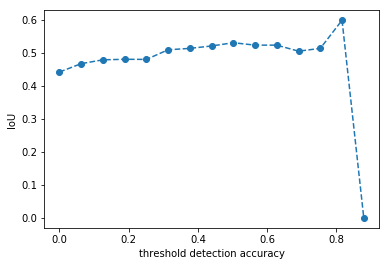

In [17]:
plt.plot(x,y,'o--')
plt.xlabel('threshold detection accuracy')
plt.ylabel('IoU')
plt.show()

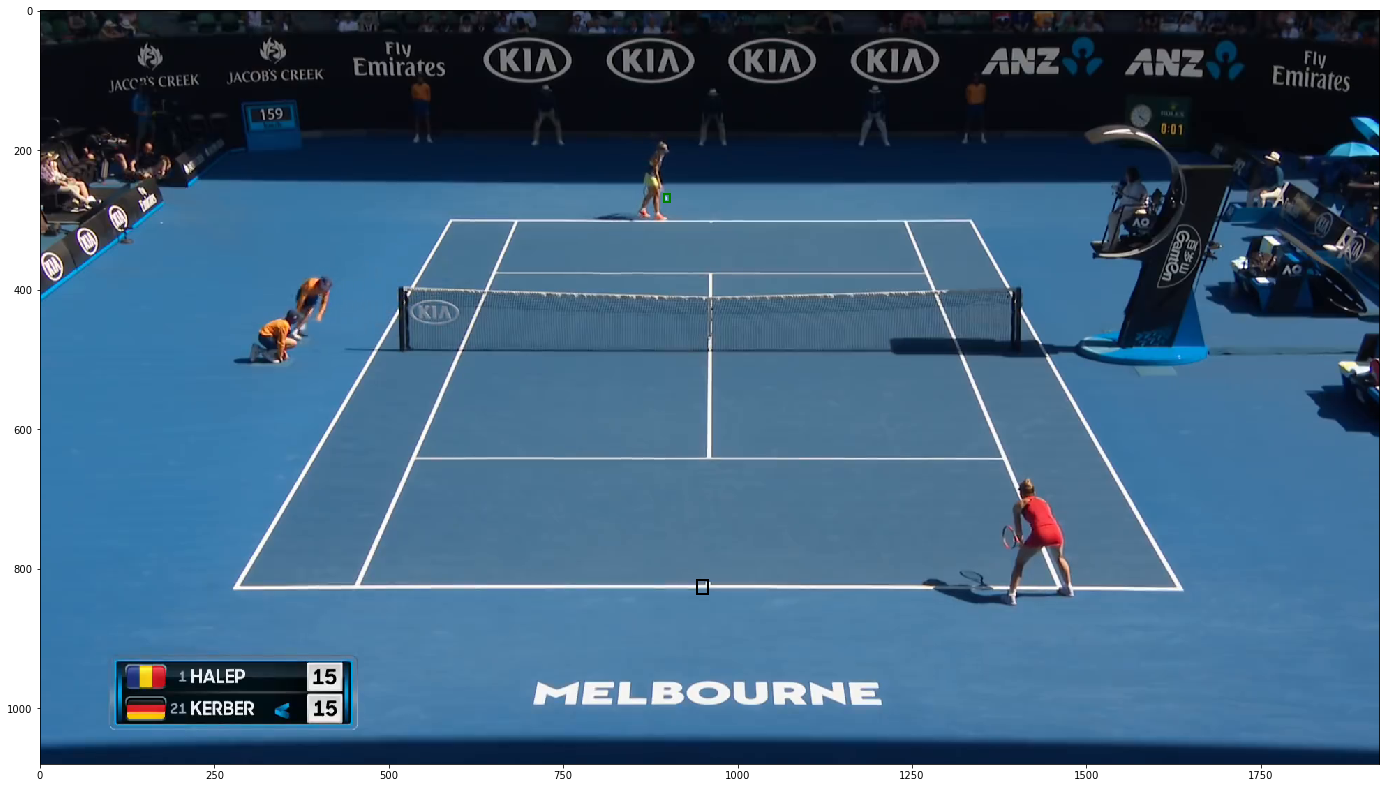

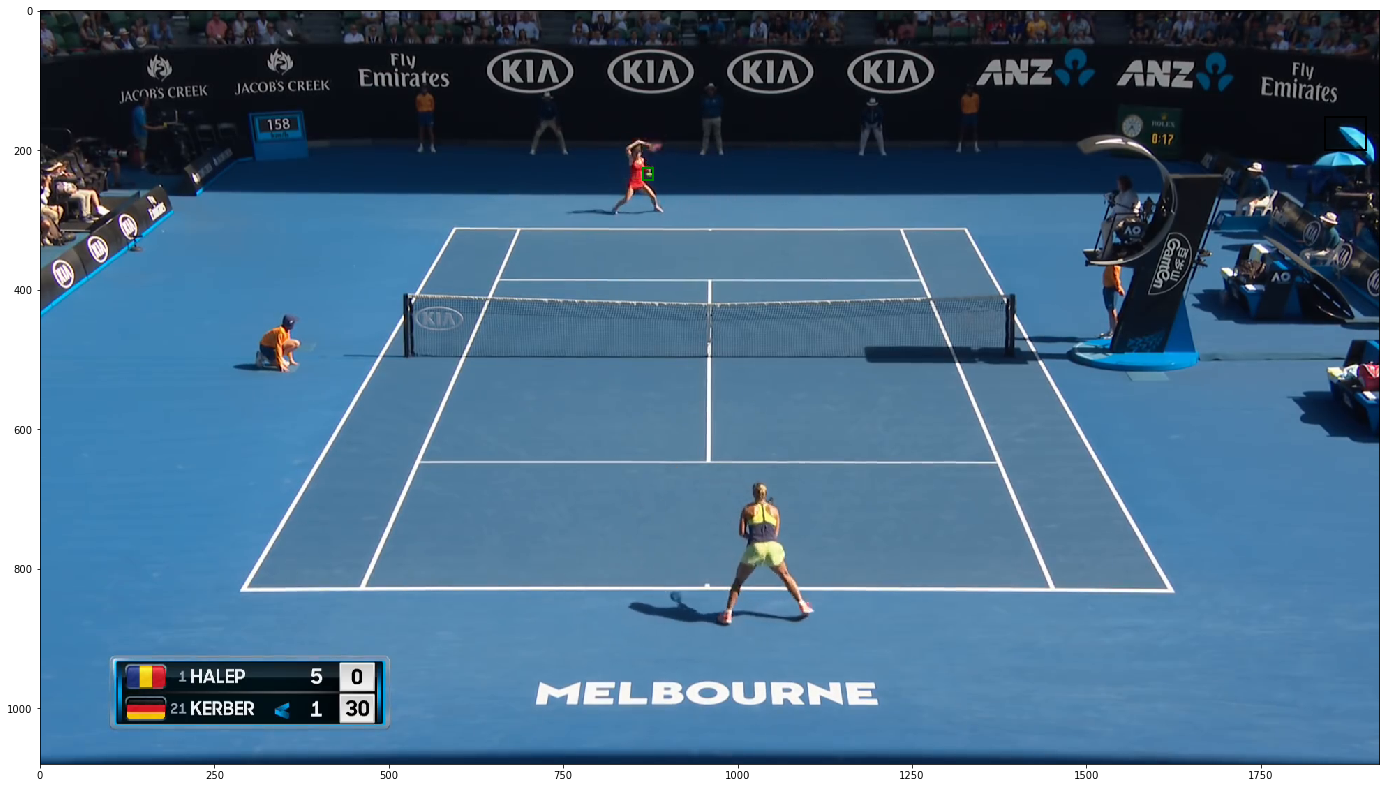

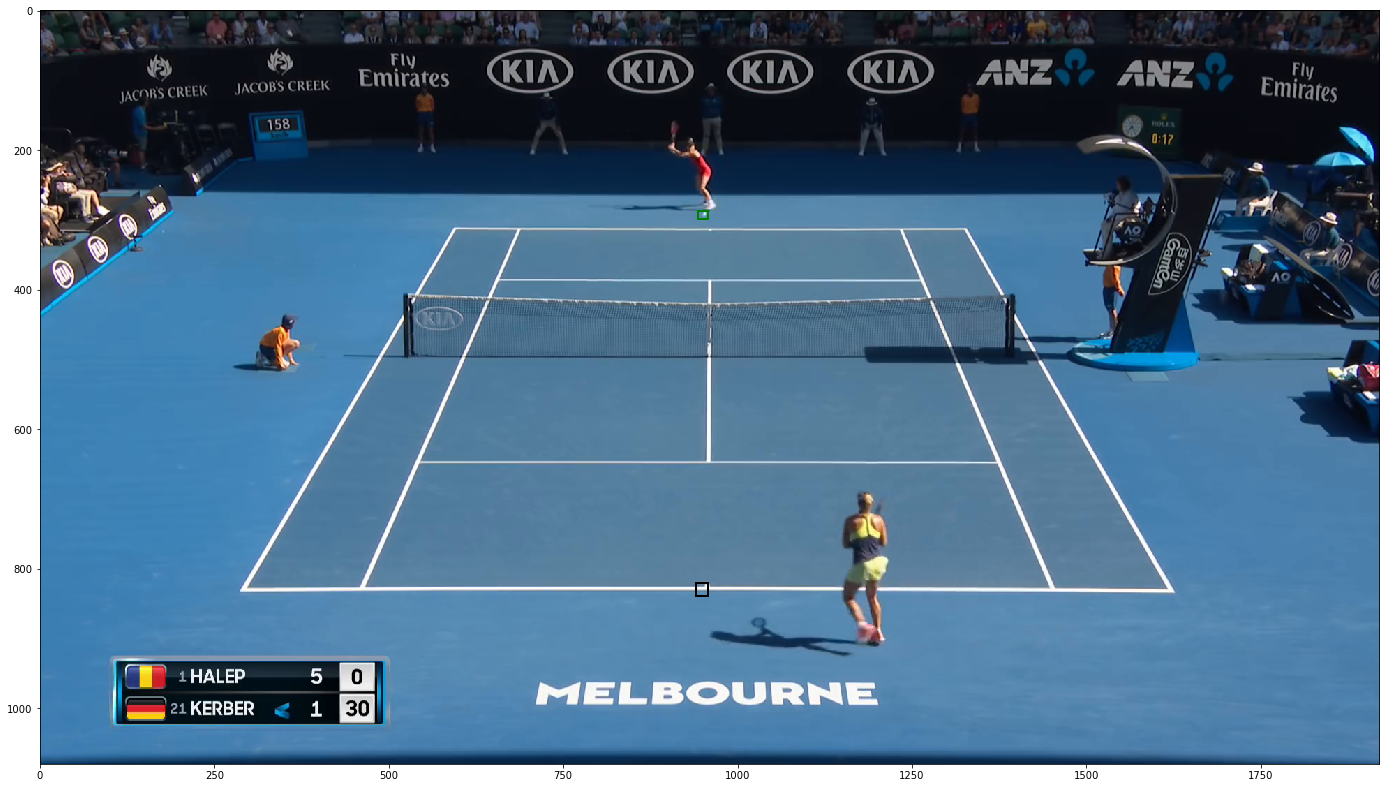

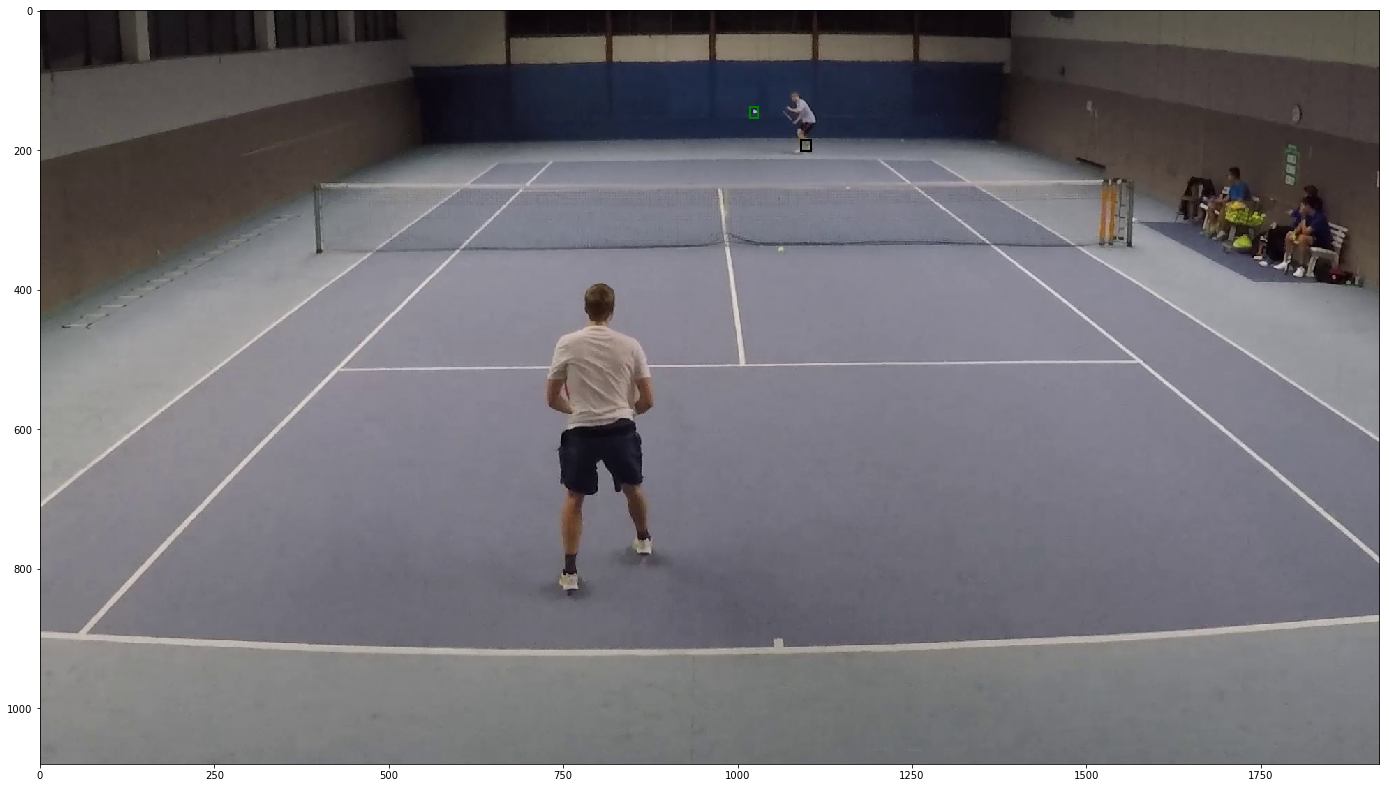

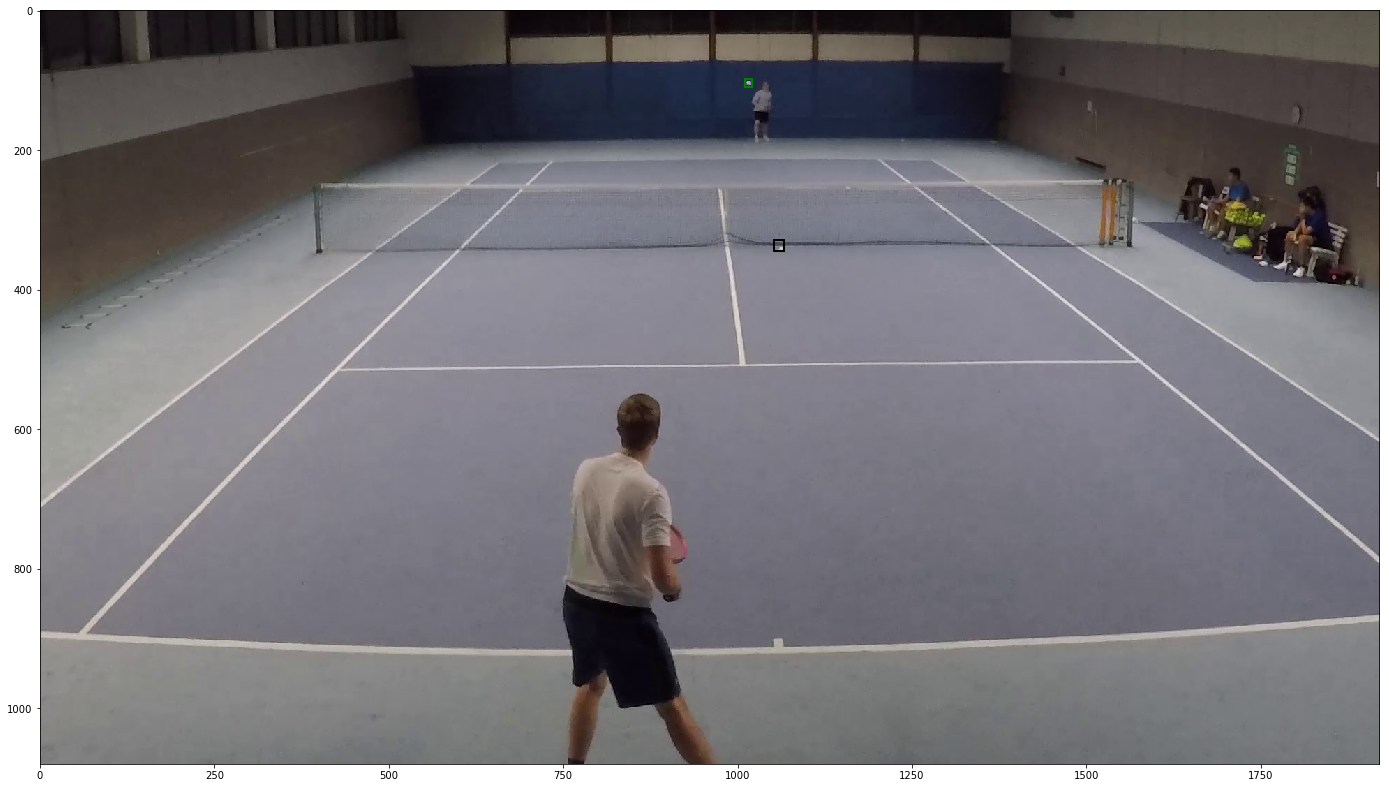

In [10]:
overlapping = []
IoU = []
DistBoxCenter = []

for k in range(len(result)):
    image = plt.imread(result.iloc[k]['filepath'])
    # Calculate edges of bounding boxed detected (d) and ground truth (g)
    s = result.iloc[k]
    d1,d2 = s['p_bb0']*image.shape[0], s['p_bb2']*image.shape[0]
    d3,d4 = s['p_bb1']*image.shape[1], s['p_bb3']*image.shape[1]
    
    g1,g2 = s['g_bb_y1'], s['g_bb_y2']
    g3,g4 = s['g_bb_x1'], s['g_bb_x2']
    
    rd = Rectangle(d3,d1,d4,d2)
    rg = Rectangle(g3,g1,g4,g2)
    
    intersect = intersectarea(rd, rg)
    darea, garea, union = unionarea(rd,rg)
    
    IoU += [intersect / union]
    
    dm = np.array([(rd.xmax+rd.xmin) / 2, (rd.ymax+rd.ymin) / 2])
    gm = np.array([(rg.xmax+rg.xmin) / 2, (rg.ymax+rg.ymin) / 2])
    DistBoxCenter += [np.linalg.norm(dm-gm)]
    
    if intersect > 0:
        overlapping += [1]
    else:
        overlapping += [0]

        plt.figure(figsize=(24,16))
        plt.imshow(image)
        plt.plot([d3, d3], [d2, d1], color='k', linestyle='-', linewidth=2)
        plt.plot([d4, d4], [d2, d1], color='k', linestyle='-', linewidth=2)
        plt.plot([d3, d4], [d1, d1], color='k', linestyle='-', linewidth=2)
        plt.plot([d3, d4], [d2, d2], color='k', linestyle='-', linewidth=2)

        plt.plot([g3, g3], [g2, g1], color='g', linestyle='-', linewidth=2)
        plt.plot([g4, g4], [g2, g1], color='g', linestyle='-', linewidth=2)
        plt.plot([g3, g4], [g1, g1], color='g', linestyle='-', linewidth=2)
        plt.plot([g3, g4], [g2, g2], color='g', linestyle='-', linewidth=2)

        plt.show()


In [11]:
overlapping = np.array(overlapping)
IoU = np.array(IoU)
DistBoxCenter = np.array(DistBoxCenter)

In [12]:
print(sum(overlapping), 'of', len(result), 'boxes do overlap', '(', 
      round(sum(overlapping)*100/len(result),2),' % )')
print('Average IoU: ', round(sum(IoU) / len(result),2))
print('Average Distance of bounding box centers:', 
      round(sum(DistBoxCenter)/len(result), 2), 'pixel')

73 of 78 boxes do overlap ( 93.59  % )
Average IoU:  0.44
Average Distance of bounding box centers: 35.85 pixel


In [13]:
distoverlapping = DistBoxCenter[np.where(np.array(overlapping) == 1)]
print('Average Distance of bounding box centers if boxes overlap:', 
      round(sum(distoverlapping)/len(distoverlapping), 2), 'pixel')

Average Distance of bounding box centers if boxes overlap: 5.09 pixel
